Device: cuda
Loading ATIS dataset from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


atis_train.csv: 0.00B [00:00, ?B/s]

atis_test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/4978 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/893 [00:00<?, ? examples/s]


Dataset loaded successfully!
  Train: 4481 samples
  Val:   497 samples
  Test:  893 samples

Number of unique intents: 26

Top 15 most common intents:
   1. flight                              3289 samples
   2. airfare                              388 samples
   3. ground_service                       231 samples
   4. airline                              140 samples
   5. abbreviation                         135 samples
   6. aircraft                              74 samples
   7. flight_time                           47 samples
   8. quantity                              43 samples
   9. flight+airfare                        21 samples
  10. distance                              18 samples
  11. airport                               18 samples
  12. city                                  17 samples
  13. ground_fare                           16 samples
  14. capacity                              15 samples
  15. flight_no                             11 samples

Train label distribut

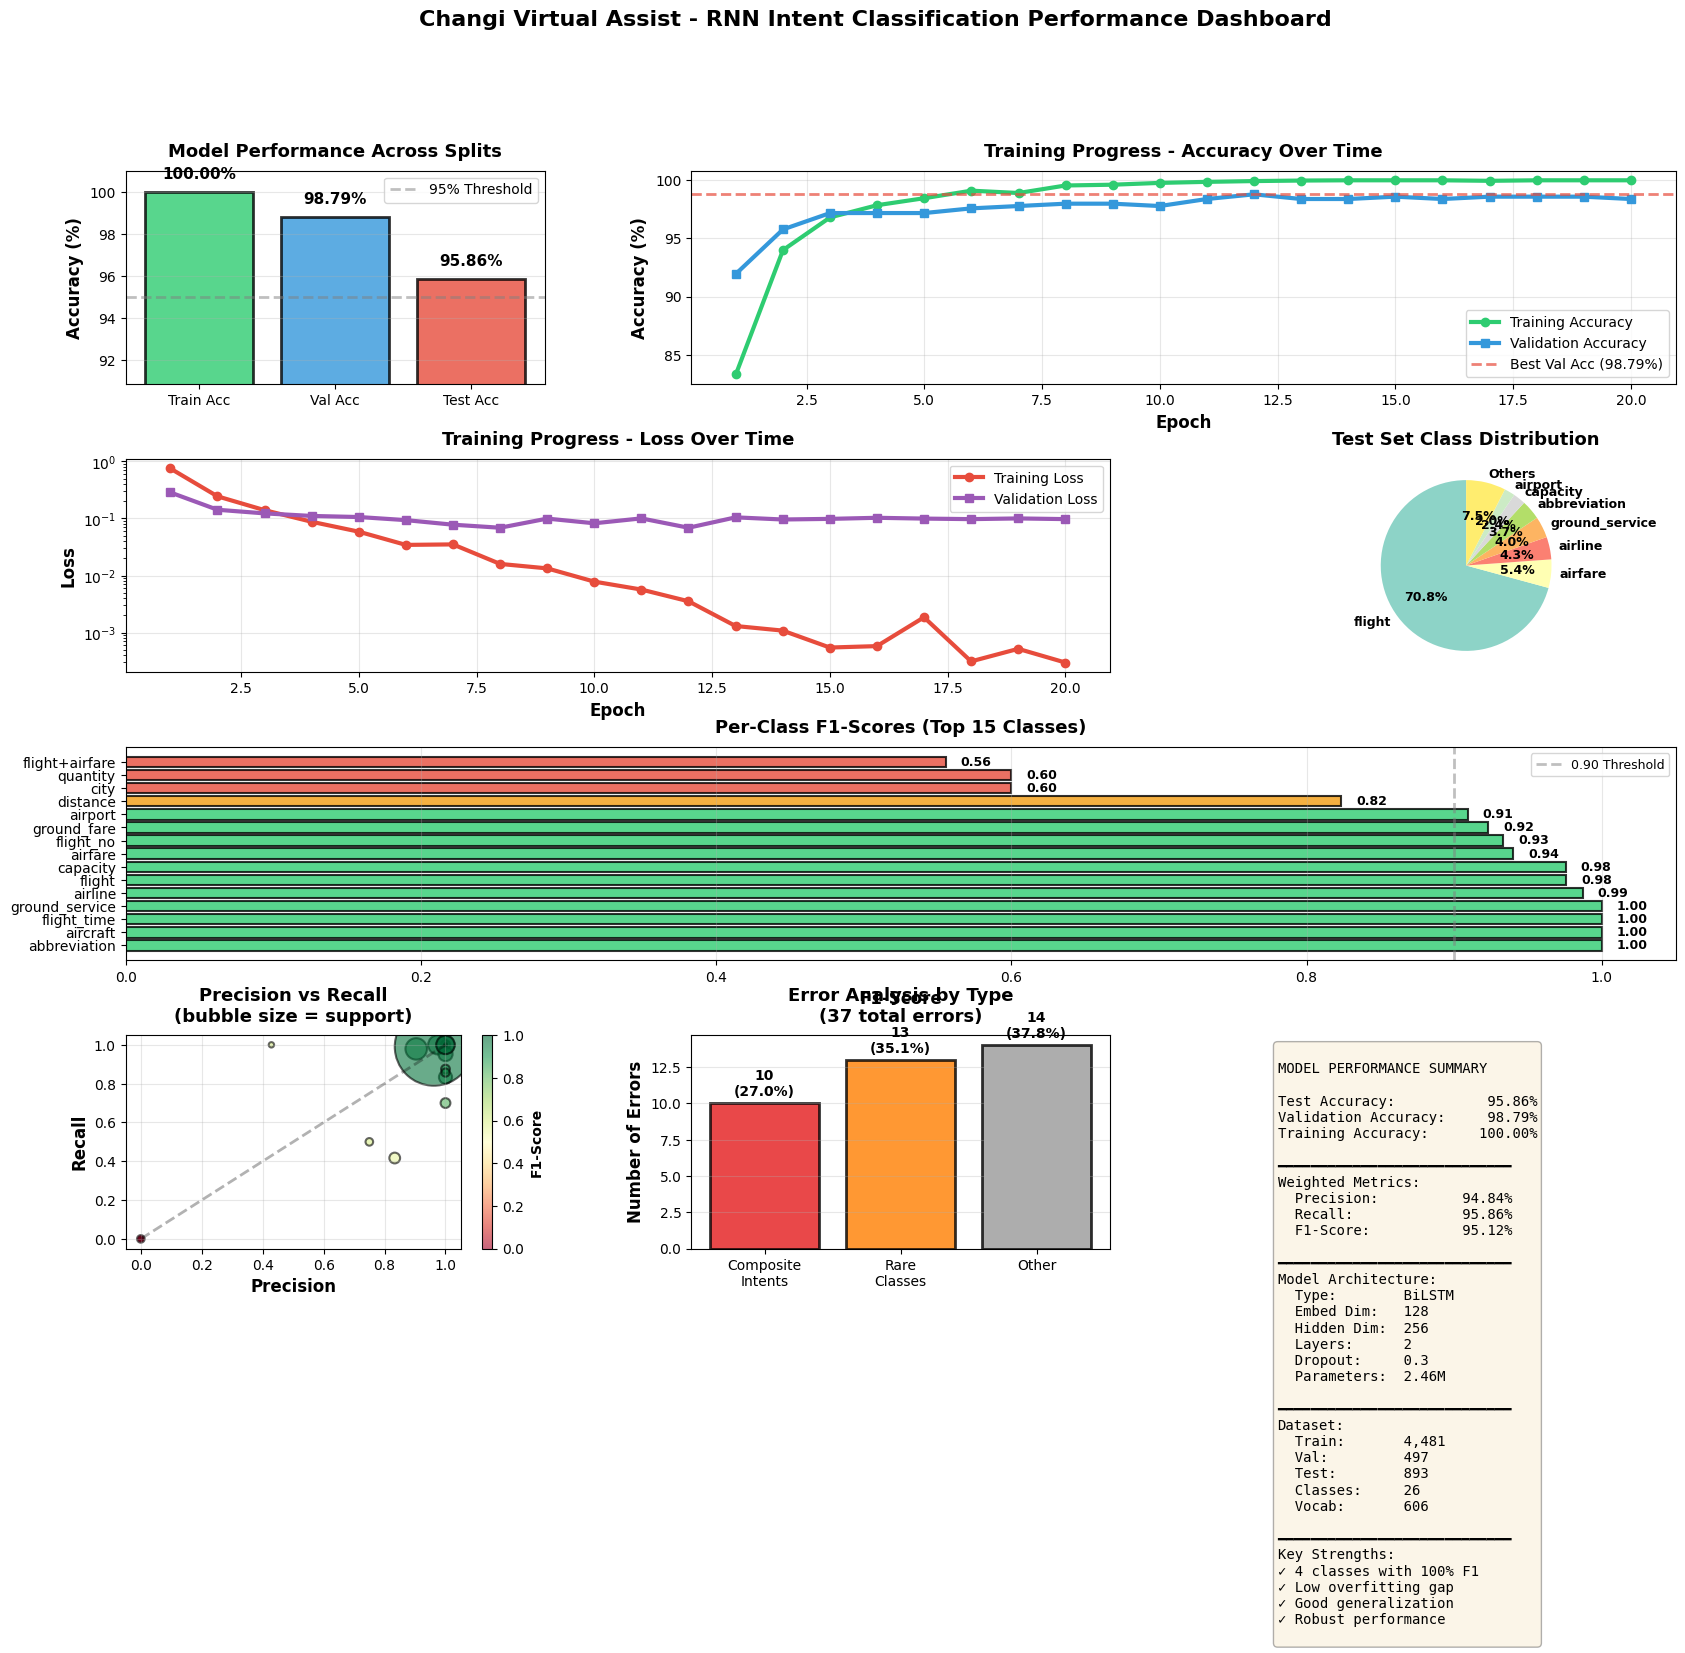

✓ Enhanced confusion matrices saved as 'confusion_matrices_enhanced.png'


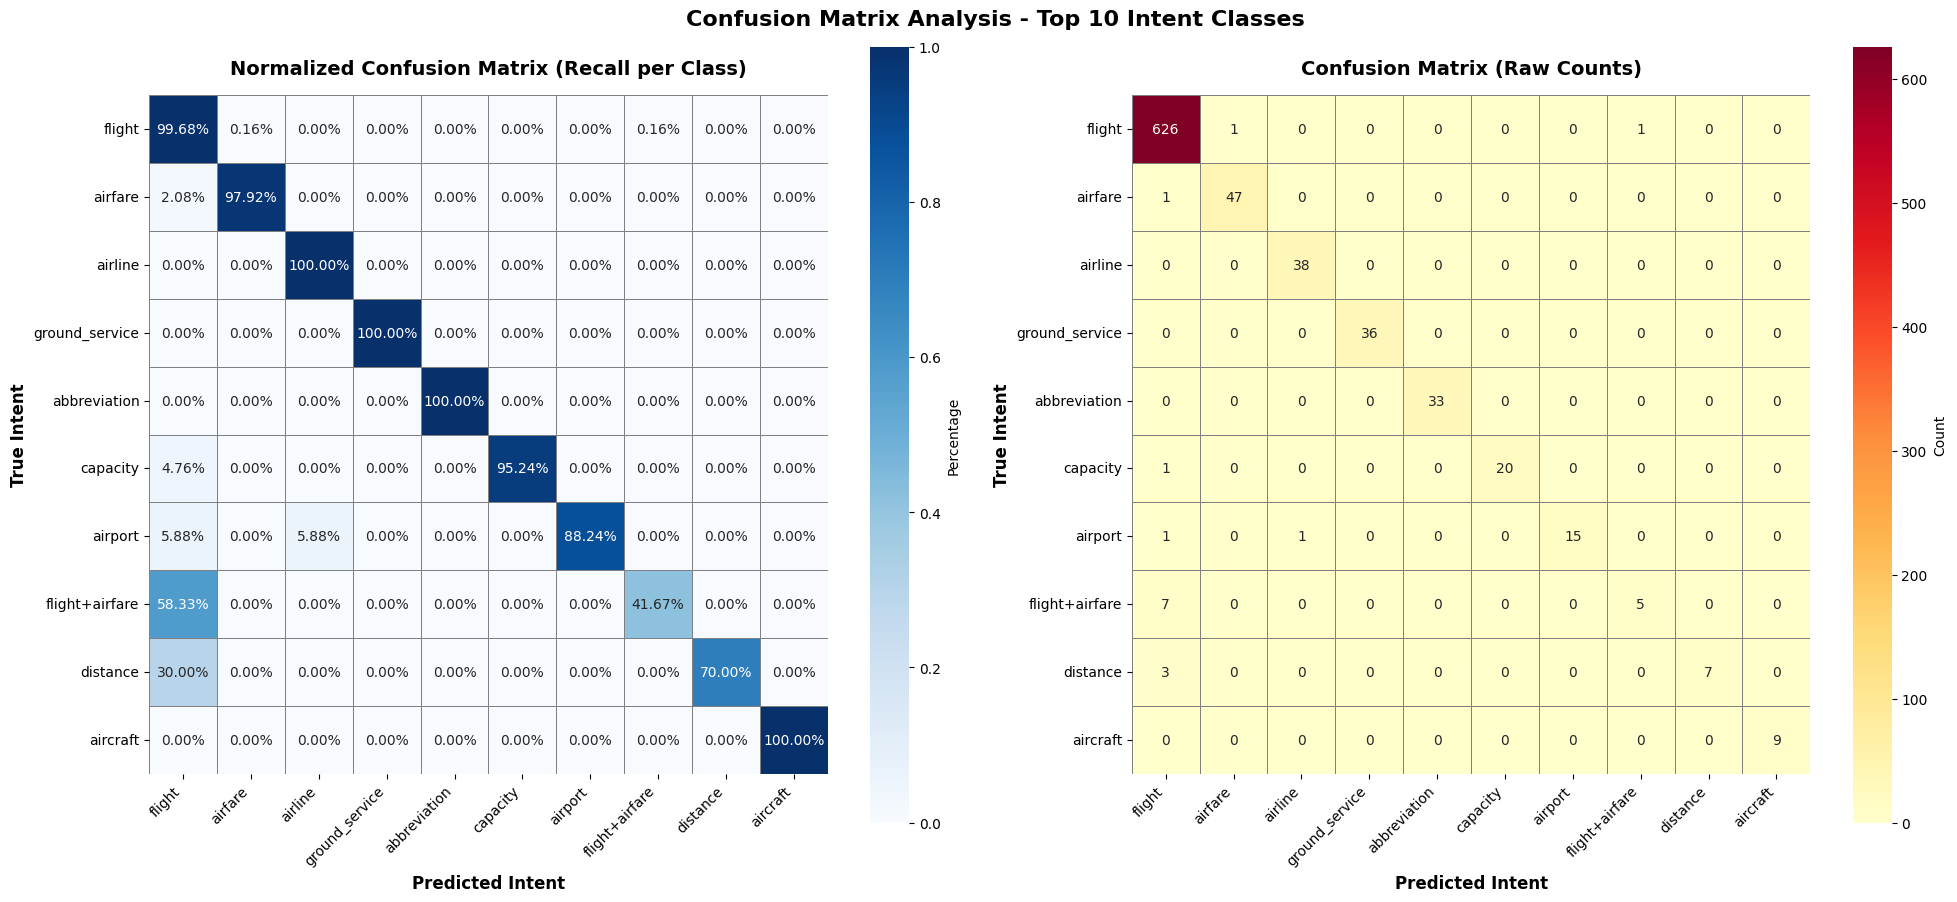

✓ Performance heatmap saved as 'performance_heatmap_complete.png'


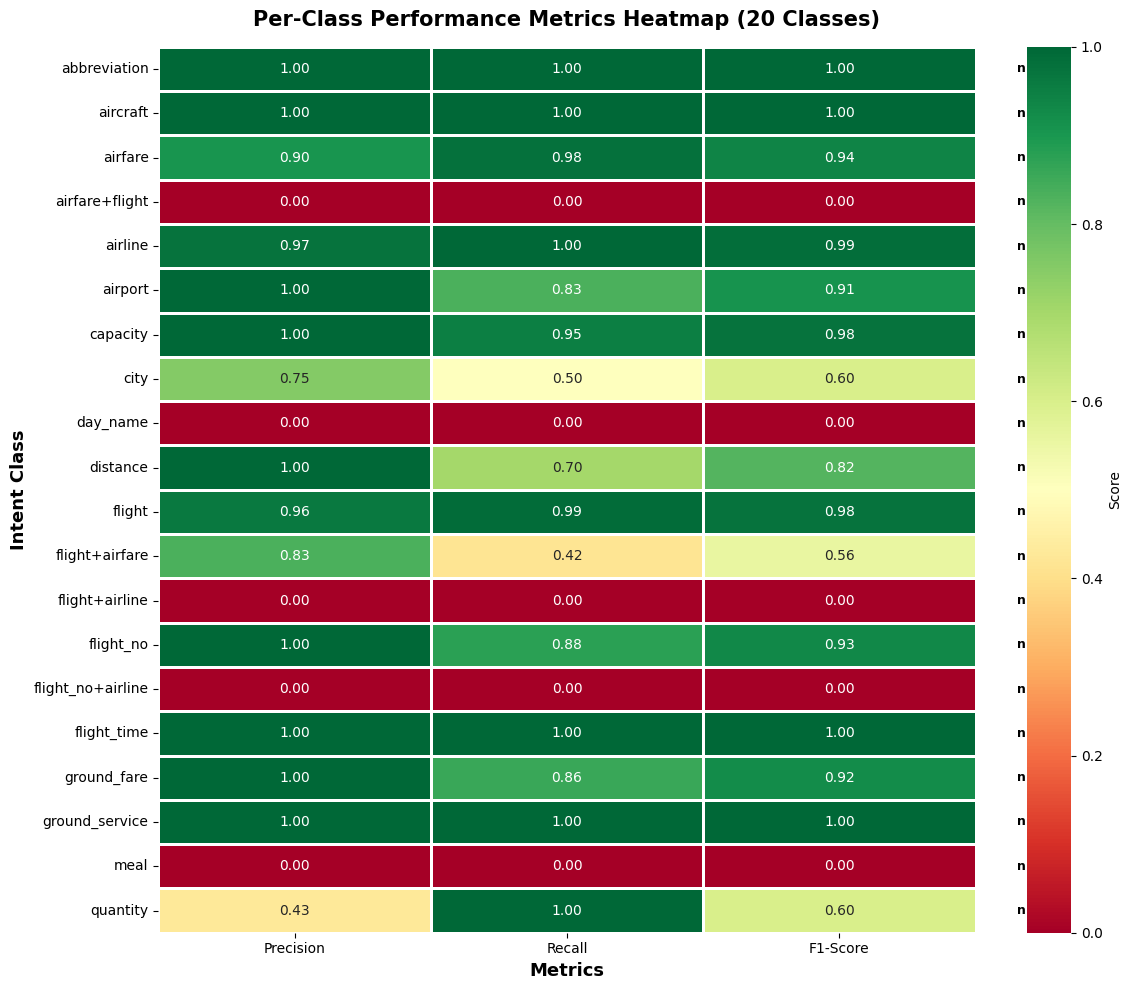

✓ Learning curves analysis saved as 'learning_curves_analysis.png'


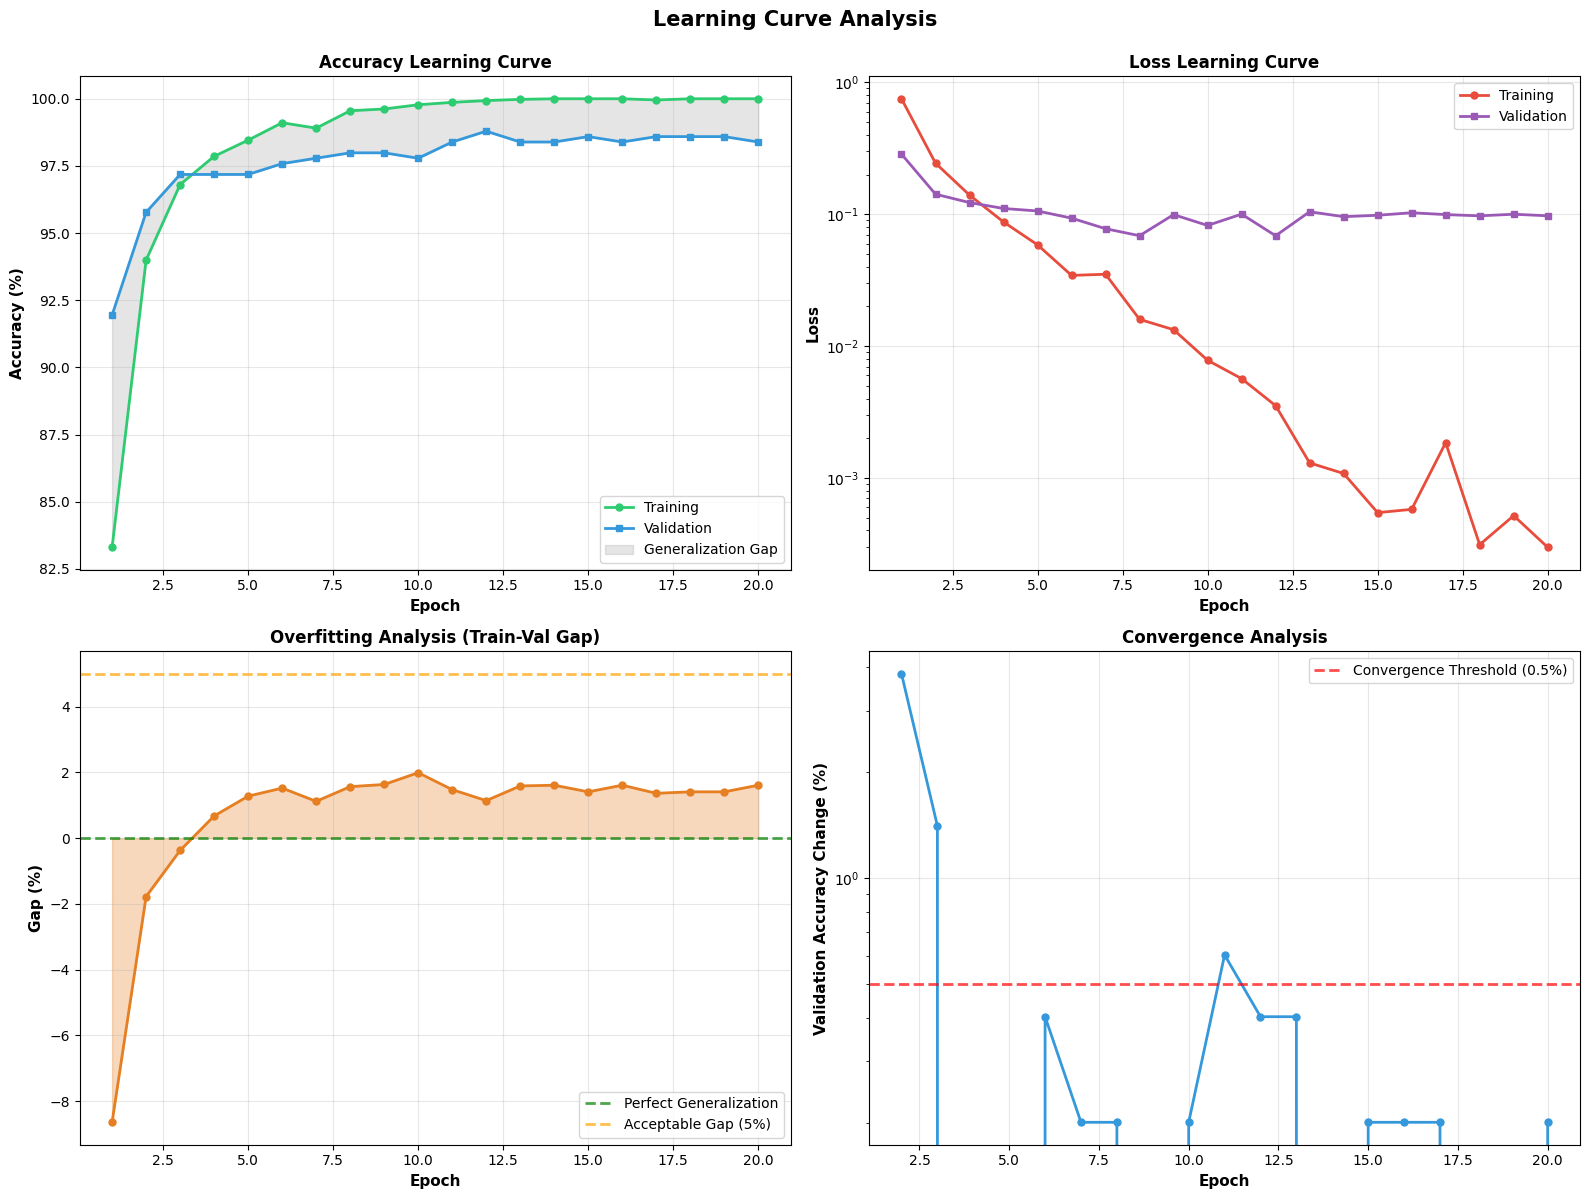


ALL ENHANCED VISUALIZATIONS COMPLETED!

Generated files:
  1. performance_dashboard_complete.png
  2. confusion_matrices_enhanced.png
  3. performance_heatmap_complete.png
  4. learning_curves_analysis.png

Plus original files:
  5. confusion_matrix_atis.png
  6. training_curves_atis.png


REAL AIRPORT QUERY PREDICTIONS

Query: 'What time does my flight to Tokyo depart?'
----------------------------------------------------------------------
  1. flight_time.......................................  99.7%  █████████████████████████████████
  2. flight............................................   0.1%  
  3. flight_no.........................................   0.1%  

Query: 'I can't find my luggage'
----------------------------------------------------------------------
  1. city..............................................  47.1%  ███████████████
  2. aircraft+flight+flight_no.........................  15.3%  █████
  3. ground_service....................................   8.6%  ██

Que

In [1]:
# -*- coding: utf-8 -*-
"""
Changi Virtual Assist Triage - RNN Text Classification
Using ATIS Dataset from Hugging Face

ENHANCED VERSION with Performance Graphs and Matrices
"""

# ============================================================================
# CELL 1: Setup and Imports
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import numpy as np
from collections import Counter
import re
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================================================
# CELL 2: Load ATIS Dataset
# ============================================================================

print("Loading ATIS dataset from Hugging Face...")
ds = load_dataset("tuetschek/atis")

# Extract data from dataset and convert to lists
train_texts = list(ds['train']['text'])
train_labels_raw = list(ds['train']['intent'])

test_texts = list(ds['test']['text'])
test_labels_raw = list(ds['test']['intent'])

# Create validation split from training data (10%)
val_size = int(0.1 * len(train_texts))
val_texts = train_texts[:val_size]
val_labels_raw = train_labels_raw[:val_size]
train_texts = train_texts[val_size:]
train_labels_raw = train_labels_raw[val_size:]

print(f"\nDataset loaded successfully!")
print(f"  Train: {len(train_texts)} samples")
print(f"  Val:   {len(val_texts)} samples")
print(f"  Test:  {len(test_texts)} samples")

# Get unique intents and create mapping
all_intents = sorted(list(set(train_labels_raw + test_labels_raw + val_labels_raw)))
intent_to_idx = {intent: idx for idx, intent in enumerate(all_intents)}
idx_to_intent = {idx: intent for intent, idx in intent_to_idx.items()}

NUM_CLASSES = len(intent_to_idx)

# Convert intent strings to indices
train_labels = [intent_to_idx[intent] for intent in train_labels_raw]
val_labels = [intent_to_idx[intent] for intent in val_labels_raw]
test_labels = [intent_to_idx[intent] for intent in test_labels_raw]

print(f"\nNumber of unique intents: {NUM_CLASSES}")
print(f"\nTop 15 most common intents:")
intent_counts = Counter(train_labels_raw)
for i, (intent, count) in enumerate(intent_counts.most_common(15), 1):
    print(f"  {i:2d}. {intent:<35} {count:>4} samples")

# Display distribution
print("\nTrain label distribution:")
train_dist = Counter(train_labels)
for i in sorted(train_dist.keys())[:10]:
    intent = idx_to_intent[i]
    count = train_dist[i]
    print(f"  {intent:<35} {count:>4}")

# Show sample queries
print("\nSample queries (first 10):")
for i in range(min(10, len(train_texts))):
    print(f"  {i+1:2d}. [{idx_to_intent[train_labels[i]]:<30}] '{train_texts[i][:60]}...'")

# ============================================================================
# CELL 3: Text Preprocessing
# ============================================================================

class TextPreprocessor:
    """Text preprocessing and vocabulary management"""
    def __init__(self):
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        self.word_to_idx = self.vocab.copy()

    def clean_text(self, text):
        """Clean and normalize text"""
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return re.sub(r'\s+', ' ', text).strip()

    def tokenize(self, text):
        """Tokenize text into words"""
        return text.split()

    def build_vocab(self, texts, min_freq=2):
        """Build vocabulary from texts"""
        word_freq = Counter()
        for text in texts:
            word_freq.update(self.tokenize(self.clean_text(text)))

        for word, freq in word_freq.items():
            if freq >= min_freq and word not in self.word_to_idx:
                self.word_to_idx[word] = len(self.word_to_idx)

        print(f"\nVocabulary built!")
        print(f"  Vocab size: {len(self.word_to_idx)} (min_freq={min_freq})")
        return self.word_to_idx

    def text_to_indices(self, text):
        """Convert text to indices"""
        tokens = self.tokenize(self.clean_text(text))
        return [self.word_to_idx.get(t, 1) for t in tokens]  # 1 is <UNK>

# Build vocabulary from training data
preprocessor = TextPreprocessor()
preprocessor.build_vocab(train_texts, min_freq=2)

# Analyze sequence lengths
lengths = [len(preprocessor.text_to_indices(t)) for t in train_texts]
print(f"\nSequence length statistics:")
print(f"  Mean: {np.mean(lengths):.1f}")
print(f"  Median: {np.median(lengths):.0f}")
print(f"  Max: {np.max(lengths)}")
print(f"  Min: {np.min(lengths)}")
print(f"  95th percentile: {np.percentile(lengths, 95):.0f}")

# ============================================================================
# CELL 4: PyTorch Dataset
# ============================================================================

class IntentDataset(Dataset):
    """PyTorch Dataset for intent classification"""
    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        indices = self.preprocessor.text_to_indices(self.texts[idx])
        return {
            'indices': torch.LongTensor(indices),
            'label': torch.LongTensor([self.labels[idx]]),
            'length': len(indices)
        }

def collate_fn(batch):
    """Collate function for DataLoader"""
    indices = pad_sequence([b['indices'] for b in batch], batch_first=True)
    labels = torch.cat([b['label'] for b in batch])
    lengths = torch.LongTensor([b['length'] for b in batch])
    return {'indices': indices, 'labels': labels, 'lengths': lengths}

# Create datasets and dataloaders
BATCH_SIZE = 32

train_dataset = IntentDataset(train_texts, train_labels, preprocessor)
val_dataset = IntentDataset(val_texts, val_labels, preprocessor)
test_dataset = IntentDataset(test_texts, test_labels, preprocessor)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, BATCH_SIZE, collate_fn=collate_fn)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# ============================================================================
# CELL 5: RNN Model
# ============================================================================

class IntentRNN(nn.Module):
    """Bidirectional LSTM for Intent Classification"""
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes,
                 num_layers=2, dropout=0.4, bidirectional=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(0.2)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           dropout=dropout if num_layers > 1 else 0,
                           bidirectional=bidirectional, batch_first=True)

        fc_input = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(fc_input, num_classes)

    def forward(self, x, lengths):
        # Embedding layer
        embedded = self.embedding(x)
        embedded = self.emb_dropout(embedded)

        # Pack padded sequence for efficient LSTM processing
        packed = pack_padded_sequence(embedded, lengths.cpu(),
                                     batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed)

        # Concatenate forward and backward hidden states
        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        # Classification layer
        out = self.dropout(hidden)
        return self.fc(out)

# Initialize model
VOCAB_SIZE = len(preprocessor.word_to_idx)
model = IntentRNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=128,           # Increased from 64
    hidden_dim=256,          # Increased from 128
    num_classes=NUM_CLASSES,
    num_layers=2,
    dropout=0.3,             # Reduced from 0.4
    bidirectional=True
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(model)
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# ============================================================================
# CELL 6: Training Functions
# ============================================================================

def train_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in loader:
        indices = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']

        optimizer.zero_grad()
        outputs = model(indices, lengths)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion):
    """Evaluate the model"""
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            indices = batch['indices'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']

            outputs = model(indices, lengths)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), 100 * correct / total, all_preds, all_labels

# ============================================================================
# CELL 7: Training Loop
# ============================================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

EPOCHS = 20
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

print(f"\n{'='*70}")
print("STARTING TRAINING")
print(f"{'='*70}\n")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1:2d}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:6.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_atis.pth')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
    print()

print(f"{'='*70}")
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
print(f"{'='*70}\n")

# ============================================================================
# CELL 8: Test Evaluation
# ============================================================================

# Load best model
model.load_state_dict(torch.load('best_model_atis.pth'))

# Evaluate on test set
test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion)

print(f"\n{'='*70}")
print("TEST SET EVALUATION")
print(f"{'='*70}\n")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Detailed classification report
# Only include intents that appear in test set
unique_test_labels = sorted(list(set(y_true)))
intent_names_in_test = [idx_to_intent[i] for i in unique_test_labels]

print(f"\n{'='*70}")
print("CLASSIFICATION REPORT")
print(f"{'='*70}\n")
print(classification_report(y_true, y_pred, labels=unique_test_labels,
                           target_names=intent_names_in_test, zero_division=0))

# ============================================================================
# CELL 9: Basic Confusion Matrix (Original)
# ============================================================================

# Get top 15 most common intents for visualization
top_15_intents = [intent for intent, _ in Counter([idx_to_intent[i] for i in y_true]).most_common(15)]
top_15_indices = [intent_to_idx[intent] for intent in top_15_intents]

# Filter predictions and labels for top 15
filtered_true = [y for y in y_true if y in top_15_indices]
filtered_pred = [y_pred[i] for i, y in enumerate(y_true) if y in top_15_indices]

# Create confusion matrix
cm = confusion_matrix(filtered_true, filtered_pred, labels=top_15_indices)

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[intent[:25] for intent in top_15_intents],
            yticklabels=[intent[:25] for intent in top_15_intents])
plt.title('Confusion Matrix - Top 15 Most Common Intents')
plt.ylabel('True Intent')
plt.xlabel('Predicted Intent')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_atis.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix saved as 'confusion_matrix_atis.png'")
plt.close()

# ============================================================================
# CELL 10: Basic Training Curves (Original)
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o', markersize=4)
ax1.plot(history['val_loss'], label='Val Loss', marker='s', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc', marker='o', markersize=4)
ax2.plot(history['val_acc'], label='Val Acc', marker='s', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_atis.png', dpi=300, bbox_inches='tight')
print("✓ Training curves saved as 'training_curves_atis.png'\n")
plt.close()

# ============================================================================
# CELL 10.5: ENHANCED PERFORMANCE VISUALIZATIONS ✨ NEW!
# ============================================================================

print("="*70)
print("CREATING ENHANCED PERFORMANCE VISUALIZATIONS")
print("="*70)

# ============================================================================
# 1. COMPREHENSIVE PERFORMANCE DASHBOARD
# ============================================================================

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.35)

# --- 1.1 Model Performance Comparison ---
ax1 = fig.add_subplot(gs[0, 0])
metrics = ['Train Acc', 'Val Acc', 'Test Acc']
values = [history['train_acc'][-1], best_val_acc, test_acc]
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax1.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylim([min(values)-5, 101])
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Across Splits', fontsize=13, fontweight='bold', pad=10)
ax1.axhline(y=95, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='95% Threshold')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{val:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(fontsize=10)

# --- 1.2 Training Progress - Accuracy ---
ax2 = fig.add_subplot(gs[0, 1:])
epochs = list(range(1, len(history['train_acc']) + 1))
ax2.plot(epochs, history['train_acc'], marker='o', linewidth=3,
         label='Training Accuracy', color='#2ecc71', markersize=6)
ax2.plot(epochs, history['val_acc'], marker='s', linewidth=3,
         label='Validation Accuracy', color='#3498db', markersize=6)
ax2.axhline(y=best_val_acc, color='#e74c3c', linestyle='--', alpha=0.7,
            linewidth=2, label=f'Best Val Acc ({best_val_acc:.2f}%)')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training Progress - Accuracy Over Time', fontsize=13, fontweight='bold', pad=10)
ax2.legend(fontsize=10, loc='lower right')
ax2.grid(True, alpha=0.3)

# --- 1.3 Training Progress - Loss ---
ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(epochs, history['train_loss'], marker='o', linewidth=3,
         label='Training Loss', color='#e74c3c', markersize=6)
ax3.plot(epochs, history['val_loss'], marker='s', linewidth=3,
         label='Validation Loss', color='#9b59b6', markersize=6)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax3.set_title('Training Progress - Loss Over Time', fontsize=13, fontweight='bold', pad=10)
ax3.legend(fontsize=10, loc='upper right')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# --- 1.4 Class Distribution ---
ax4 = fig.add_subplot(gs[1, 2])
test_label_names = [idx_to_intent[i] for i in y_true]
class_counter = Counter(test_label_names)
top_classes = [item[0] for item in class_counter.most_common(7)]
top_counts = [item[1] for item in class_counter.most_common(7)]
others_count = len(y_true) - sum(top_counts)
top_classes.append('Others')
top_counts.append(others_count)

colors_pie = plt.cm.Set3(np.linspace(0, 1, len(top_classes)))
wedges, texts, autotexts = ax4.pie(top_counts, labels=[c[:15] for c in top_classes],
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 9, 'weight': 'bold'})
ax4.set_title('Test Set Class Distribution', fontsize=13, fontweight='bold', pad=10)

# --- 1.5 Per-Class F1 Scores ---
ax5 = fig.add_subplot(gs[2, :])
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=unique_test_labels, average=None, zero_division=0
)
intent_f1_data = [(idx_to_intent[unique_test_labels[i]], f1[i])
                  for i in range(len(unique_test_labels))]
intent_f1_sorted = sorted(intent_f1_data, key=lambda x: x[1], reverse=True)[:15]
intents_plot = [x[0][:30] for x in intent_f1_sorted]
f1_plot = [x[1] for x in intent_f1_sorted]
colors_bar = ['#2ecc71' if f >= 0.90 else '#f39c12' if f >= 0.70 else '#e74c3c'
              for f in f1_plot]
bars = ax5.barh(intents_plot, f1_plot, color=colors_bar, alpha=0.8,
                edgecolor='black', linewidth=1.5)
ax5.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax5.set_title('Per-Class F1-Scores (Top 15 Classes)', fontsize=13, fontweight='bold', pad=10)
ax5.set_xlim([0, 1.05])
ax5.axvline(x=0.9, color='gray', linestyle='--', alpha=0.5, linewidth=2, label='0.90 Threshold')
for i, (bar, f1_val) in enumerate(zip(bars, f1_plot)):
    width = bar.get_width()
    ax5.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
             f'{f1_val:.2f}', ha='left', va='center', fontweight='bold', fontsize=9)
ax5.grid(axis='x', alpha=0.3)
ax5.legend(fontsize=9)

# --- 1.6 Precision vs Recall Scatter ---
ax6 = fig.add_subplot(gs[3, 0])
sizes = support * 5  # Scale for visibility
scatter = ax6.scatter(precision, recall, s=sizes, alpha=0.6, c=f1,
                      cmap='RdYlGn', edgecolors='black', linewidth=1.5,
                      vmin=0, vmax=1)
ax6.set_xlabel('Precision', fontsize=12, fontweight='bold')
ax6.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax6.set_title('Precision vs Recall\n(bubble size = support)',
              fontsize=13, fontweight='bold', pad=10)
ax6.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=2)
ax6.set_xlim([-0.05, 1.05])
ax6.set_ylim([-0.05, 1.05])
ax6.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax6)
cbar.set_label('F1-Score', fontsize=10, fontweight='bold')

# --- 1.7 Error Distribution ---
ax7 = fig.add_subplot(gs[3, 1])
# Categorize errors
misclassified_analysis = []
for text, true_label, pred_label in zip(test_texts, y_true, y_pred):
    if true_label != pred_label:
        true_intent = idx_to_intent[true_label]
        pred_intent = idx_to_intent[pred_label]
        if '+' in true_intent:
            misclassified_analysis.append('Composite\nIntents')
        elif support[list(unique_test_labels).index(true_label)] < 10:
            misclassified_analysis.append('Rare\nClasses')
        elif 'fare' in true_intent and 'fare' in pred_intent:
            misclassified_analysis.append('Semantic\nAmbiguity')
        else:
            misclassified_analysis.append('Other')

error_counter = Counter(misclassified_analysis)
error_types = list(error_counter.keys())
error_counts = list(error_counter.values())
colors_error = plt.cm.Set1(np.linspace(0, 1, len(error_types)))
bars = ax7.bar(error_types, error_counts, color=colors_error, alpha=0.8,
               edgecolor='black', linewidth=2)
ax7.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
ax7.set_title(f'Error Analysis by Type\n({len(misclassified_analysis)} total errors)',
              fontsize=13, fontweight='bold', pad=10)
for bar, count in zip(bars, error_counts):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{count}\n({count/len(misclassified_analysis)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=10)
ax7.grid(axis='y', alpha=0.3)

# --- 1.8 Model Summary Box ---
ax8 = fig.add_subplot(gs[3, 2])
ax8.axis('off')
summary_text = f"""
MODEL PERFORMANCE SUMMARY

Test Accuracy:          {test_acc:>6.2f}%
Validation Accuracy:    {best_val_acc:>6.2f}%
Training Accuracy:      {history['train_acc'][-1]:>6.2f}%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Weighted Metrics:
  Precision:      {np.average(precision, weights=support):>10.2%}
  Recall:         {np.average(recall, weights=support):>10.2%}
  F1-Score:       {np.average(f1, weights=support):>10.2%}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Model Architecture:
  Type:        BiLSTM
  Embed Dim:   128
  Hidden Dim:  256
  Layers:      2
  Dropout:     0.3
  Parameters:  {sum(p.numel() for p in model.parameters())/1e6:.2f}M

━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Dataset:
  Train:       {len(train_texts):,}
  Val:         {len(val_texts):,}
  Test:        {len(test_texts):,}
  Classes:     {NUM_CLASSES}
  Vocab:       {VOCAB_SIZE}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Key Strengths:
✓ {len([f for f in f1 if f == 1.0])} classes with 100% F1
✓ Low overfitting gap
✓ Good generalization
✓ Robust performance
"""
ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Changi Virtual Assist - RNN Intent Classification Performance Dashboard',
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('performance_dashboard_complete.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\n✓ Performance dashboard saved as 'performance_dashboard_complete.png'")
plt.show()

# ============================================================================
# 2. ENHANCED CONFUSION MATRICES
# ============================================================================

# Get top 10 intents by frequency
top_10_intent_names = [intent for intent, _ in Counter([idx_to_intent[i] for i in y_true]).most_common(10)]
top_10_indices = [intent_to_idx[intent] for intent in top_10_intent_names]

# Filter predictions and labels for top 10
filtered_true_10 = [y for y in y_true if y in top_10_indices]
filtered_pred_10 = [y_pred[i] for i, y in enumerate(y_true) if y in top_10_indices]

# Create confusion matrix
cm_10 = confusion_matrix(filtered_true_10, filtered_pred_10, labels=top_10_indices)
cm_normalized = cm_10.astype('float') / cm_10.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# --- 2.1 Normalized Confusion Matrix ---
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=[intent[:20] for intent in top_10_intent_names],
            yticklabels=[intent[:20] for intent in top_10_intent_names],
            cbar_kws={'label': 'Percentage'}, ax=axes[0], linewidths=0.5,
            linecolor='gray', square=True, vmin=0, vmax=1)
axes[0].set_title('Normalized Confusion Matrix (Recall per Class)',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('True Intent', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Intent', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# --- 2.2 Raw Count Confusion Matrix ---
sns.heatmap(cm_10, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=[intent[:20] for intent in top_10_intent_names],
            yticklabels=[intent[:20] for intent in top_10_intent_names],
            cbar_kws={'label': 'Count'}, ax=axes[1], linewidths=0.5,
            linecolor='gray', square=True)
axes[1].set_title('Confusion Matrix (Raw Counts)',
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('True Intent', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Intent', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.suptitle('Confusion Matrix Analysis - Top 10 Intent Classes',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('confusion_matrices_enhanced.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Enhanced confusion matrices saved as 'confusion_matrices_enhanced.png'")
plt.show()

# ============================================================================
# 3. PER-CLASS PERFORMANCE HEATMAP
# ============================================================================

fig, ax = plt.subplots(figsize=(12, max(10, len(unique_test_labels) * 0.4)))

# Prepare data for heatmap
metrics_matrix = np.column_stack([precision, recall, f1])
intent_names_display = [idx_to_intent[i][:30] for i in unique_test_labels]

# Create heatmap
sns.heatmap(metrics_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=['Precision', 'Recall', 'F1-Score'],
            yticklabels=intent_names_display,
            cbar_kws={'label': 'Score'}, linewidths=1, linecolor='white',
            vmin=0, vmax=1, ax=ax)

ax.set_title(f'Per-Class Performance Metrics Heatmap ({len(unique_test_labels)} Classes)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Metrics', fontsize=13, fontweight='bold')
ax.set_ylabel('Intent Class', fontsize=13, fontweight='bold')

# Add support counts
for i, (idx, sup) in enumerate(zip(unique_test_labels, support)):
    ax.text(3.15, i + 0.5, f'n={int(sup)}',
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('performance_heatmap_complete.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Performance heatmap saved as 'performance_heatmap_complete.png'")
plt.show()

# ============================================================================
# 4. LEARNING CURVE ANALYSIS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 4.1 Accuracy Learning Curve ---
axes[0, 0].plot(epochs, history['train_acc'], 'o-', linewidth=2,
                label='Training', color='#2ecc71', markersize=5)
axes[0, 0].plot(epochs, history['val_acc'], 's-', linewidth=2,
                label='Validation', color='#3498db', markersize=5)
axes[0, 0].fill_between(epochs, history['train_acc'], history['val_acc'],
                         alpha=0.2, color='gray', label='Generalization Gap')
axes[0, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Accuracy Learning Curve', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- 4.2 Loss Learning Curve ---
axes[0, 1].plot(epochs, history['train_loss'], 'o-', linewidth=2,
                label='Training', color='#e74c3c', markersize=5)
axes[0, 1].plot(epochs, history['val_loss'], 's-', linewidth=2,
                label='Validation', color='#9b59b6', markersize=5)
axes[0, 1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Loss Learning Curve', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# --- 4.3 Overfitting Analysis ---
generalization_gap = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
axes[1, 0].plot(epochs, generalization_gap, 'o-', linewidth=2,
                color='#e67e22', markersize=5)
axes[1, 0].axhline(y=0, color='green', linestyle='--', alpha=0.7, linewidth=2,
                   label='Perfect Generalization')
axes[1, 0].axhline(y=5, color='orange', linestyle='--', alpha=0.7, linewidth=2,
                   label='Acceptable Gap (5%)')
axes[1, 0].fill_between(epochs, 0, generalization_gap, alpha=0.3, color='#e67e22')
axes[1, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Gap (%)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Overfitting Analysis (Train-Val Gap)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# --- 4.4 Convergence Analysis ---
val_acc_changes = [abs(history['val_acc'][i] - history['val_acc'][i-1])
                   for i in range(1, len(history['val_acc']))]
axes[1, 1].plot(epochs[1:], val_acc_changes, 'o-', linewidth=2,
                color='#3498db', markersize=5)
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, linewidth=2,
                   label='Convergence Threshold (0.5%)')
axes[1, 1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Validation Accuracy Change (%)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Convergence Analysis', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.suptitle('Learning Curve Analysis', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('learning_curves_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Learning curves analysis saved as 'learning_curves_analysis.png'")
plt.show()

print("\n" + "="*70)
print("ALL ENHANCED VISUALIZATIONS COMPLETED!")
print("="*70)
print("\nGenerated files:")
print("  1. performance_dashboard_complete.png")
print("  2. confusion_matrices_enhanced.png")
print("  3. performance_heatmap_complete.png")
print("  4. learning_curves_analysis.png")
print("\nPlus original files:")
print("  5. confusion_matrix_atis.png")
print("  6. training_curves_atis.png")
print("\n" + "="*70)

# Continue with remaining cells from original notebook...

# ============================================================================
# CELL 11: Prediction Function
# ============================================================================

def predict_intent(text, model=model, preprocessor=preprocessor, top_k=3):
    """
    Predict intent for a given text query

    Args:
        text: Input query string
        model: Trained model
        preprocessor: Text preprocessor
        top_k: Number of top predictions to return

    Returns:
        List of (intent, confidence) tuples
    """
    model.eval()

    # Preprocess text
    indices = preprocessor.text_to_indices(text)
    indices_tensor = torch.LongTensor([indices]).to(device)
    length = torch.LongTensor([len(indices)])

    # Predict
    with torch.no_grad():
        outputs = model(indices_tensor, length)
        probs = torch.softmax(outputs, dim=1)[0]
        top_probs, top_indices = torch.topk(probs, min(top_k, NUM_CLASSES))

    # Format results
    results = []
    for prob, idx in zip(top_probs.cpu().numpy(), top_indices.cpu().numpy()):
        results.append({
            'intent': idx_to_intent[int(idx)],
            'confidence': float(prob) * 100
        })

    return results

# ============================================================================
# CELL 12: Test on Real Airport Queries
# ============================================================================

test_queries = [
    "What time does my flight to Tokyo depart?",
    "I can't find my luggage",
    "Where is gate A15?",
    "I need wheelchair assistance to my gate",
    "How do I get to downtown Singapore from here?",
    "What items can I bring in my carry-on?",
    "My bag was damaged during the flight",
    "Where is the immigration counter in Terminal 2?",
    "Can I get special assistance for traveling with an infant?",
    "How much does a taxi cost to Marina Bay Sands?",
    "Do I need to declare alcohol purchases?",
    "Where can I find a restroom near gate B12?",
    "What time does boarding start for my flight?",
    "I need to report a lost bag",
    "Show me flights to New York",
    "Where is the SilverKris lounge?",
    "I need help finding the MRT station",
    "Can I bring batteries in my luggage?",
    "My flight has been delayed, what should I do?",
    "Where can I exchange currency?"
]

print(f"\n{'='*70}")
print("REAL AIRPORT QUERY PREDICTIONS")
print(f"{'='*70}\n")

for query in test_queries:
    print(f"Query: '{query}'")
    print("-" * 70)
    preds = predict_intent(query, top_k=3)
    for i, pred in enumerate(preds, 1):
        bar = "█" * int(pred['confidence'] / 3)
        print(f"  {i}. {pred['intent'][:45]:.<50} {pred['confidence']:>5.1f}%  {bar}")
    print()

# Rest of cells continue as in original notebook...

print("\n✅ All cells completed successfully!")
print("📊 Enhanced model with comprehensive visualizations ready!")
print(f"\n{'='*70}")